In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chaosmagpy.model_utils import design_gauss
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from alberte_klara_lib import do_design, plot_map_three
from alberte_klara_lib import n_int_max, n_ext_max, theta_grid, phi_grid
import os

In [7]:
data_dst = "ready_oersted_data\oersted_dark_quiet.txt"
data = pd.read_table(data_dst, delimiter = ",")
data

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\alber\AppData\Local\Temp\ipykernel_16256\1198532005.py:1: SyntaxWarning: invalid escape sequence '\o'
  data_dst = "ready_oersted_data\oersted_dark_quiet.txt"


time_stamp    radius     colat       lon       B_r   B_theta    B_phi  \
0     -180.592967  7062.271   59.2412 -135.7557 -24903.41 -18948.13  4911.32   
1     -179.402650  7029.945  111.6406  148.9944  28497.94 -23073.11  4179.94   
2     -179.399629  7037.983  127.6251  145.4625  40528.63 -16187.60  3668.19   
3     -179.398775  7041.610  132.1228  144.2809  42956.53 -13879.66  3319.22   
4     -179.397934  7045.737  136.5383  142.9883  44900.67 -11473.02  2885.29   
...           ...       ...       ...       ...       ...       ...      ...   
47725    3.956973  7239.201   84.4464  -18.7071   1934.03 -19067.21 -3888.41   
47726    3.957709  7237.607   88.1296  -19.3923   4311.00 -18094.52 -4130.18   
47727    3.958444  7235.544   91.8147  -20.0760   6381.86 -17009.89 -4329.24   
47728    3.959298  7232.573   96.0949  -20.8723   8401.44 -15689.38 -4499.83   
47729    3.960034  7229.532   99.7852  -21.5648   9800.19 -14586.67 -4576.10   

              X        Y         Z      dDst      Hp30             F  B_radius  
0      18948.13  4911.32  24903.41  0.000000  0.667000  31675.424611 -24903.41  
1      23073.11  4179.94 -28497.94  1.672657  1.115078  36904.916850  28497.94  
2      16187.60  3668.19 -40528.63  1.817675  1.211668  43795.705969  40528.63  
3      13879.66  3319.22 -42956.53  1.858659  1.238966  45265.059955  42956.53  
4      11473.02  2885.29 -44900.67  1.899010  1.265842  46433.018992  44900.67  
...         ...      ...       ...       ...       ...           ...       ...  
47725  19067.21 -3888.41  -1934.03  2.205868  2.732288  19555.528670   1934.03  
47726  18094.52 -4130.18  -4311.00  2.364752  2.696978  19053.995955   4311.00  
47727  17009.89 -4329.24  -6381.86  2.523631  2.665219  18676.370468   6381.86  
47728  15689.38 -4499.83  -8401.44  2.708048  2.651530  18357.268557   8401.44  
47729  14586.67 -4576.10  -9800.19  2.866931  2.639737  18159.167297   9800.19  

[47730 rows x 14 columns]

In [8]:
nm_static = (n_int_max + 1)**2 - 1 + (n_ext_max + 1)**2 - 1
n_obs = len(data)

# lhs and rhs of lst sq prb will have to be constructed bit by bit
# allocating these in memory
lhs = np.zeros((nm_static, nm_static)) # G.T@G
rhs = np.zeros((nm_static,)) # G.T@d

# taking 10k data point at a time (sub matrix, chunk of data, G_sub) - but still all model parameters
i = 0
while (i <= n_obs - 10*10**3):
    i10k = i + 10*10**3

    G_int = np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], nmax=n_int_max)))
    print(G_int.shape)
    G_ext = np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], nmax=n_ext_max, source = 'external')))
    G = np.hstack((G_int, G_ext))
    lhs += G.T@G

    d = np.hstack((data['B_radius'].iloc[i:i10k], data['B_theta'].iloc[i:i10k], data['B_phi'].iloc[i:i10k]))
    rhs += G.T@d
    i += 10*10**3

G_int = np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_int_max)))
G_ext = np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_ext_max, source = 'external')))
G = np.hstack((G_int, G_ext))
lhs += G.T@G

d = np.hstack((data['B_radius'].iloc[i:], data['B_theta'].iloc[i:], data['B_phi'].iloc[i:]))
rhs += G.T@d


m = np.linalg.solve(lhs, rhs)

m_int_static = m[:-((n_ext_max + 1)**2 - 1)]
m_ext_static = m[-((n_ext_max + 1)**2 - 1):]

np.savetxt(os.path.join('ready_oersted_data', 'int_model_static_parameters'), m_int_static)
np.savetxt(os.path.join('ready_oersted_data', 'ext_model_static_parameters'), m_ext_static)

(30000, 195)
(30000, 195)
(30000, 195)
(30000, 195)


In [9]:
# Predicted field at Swarm altitude
G_pred_static_radius, G_pred_static_theta, G_pred_static_phi = do_design(data['radius'], data['colat'], data['lon'], n_int_max, n_ext_max)

b_pred_static_radius = G_pred_static_radius @ m
b_pred_static_theta = G_pred_static_theta @ m
b_pred_static_phi = G_pred_static_phi @ m

# field intensity
F_pred_static = np.sqrt(b_pred_static_radius**2 + b_pred_static_theta**2 + b_pred_static_phi**2)

# plot?

# Residuals between model-predicted field and measured field

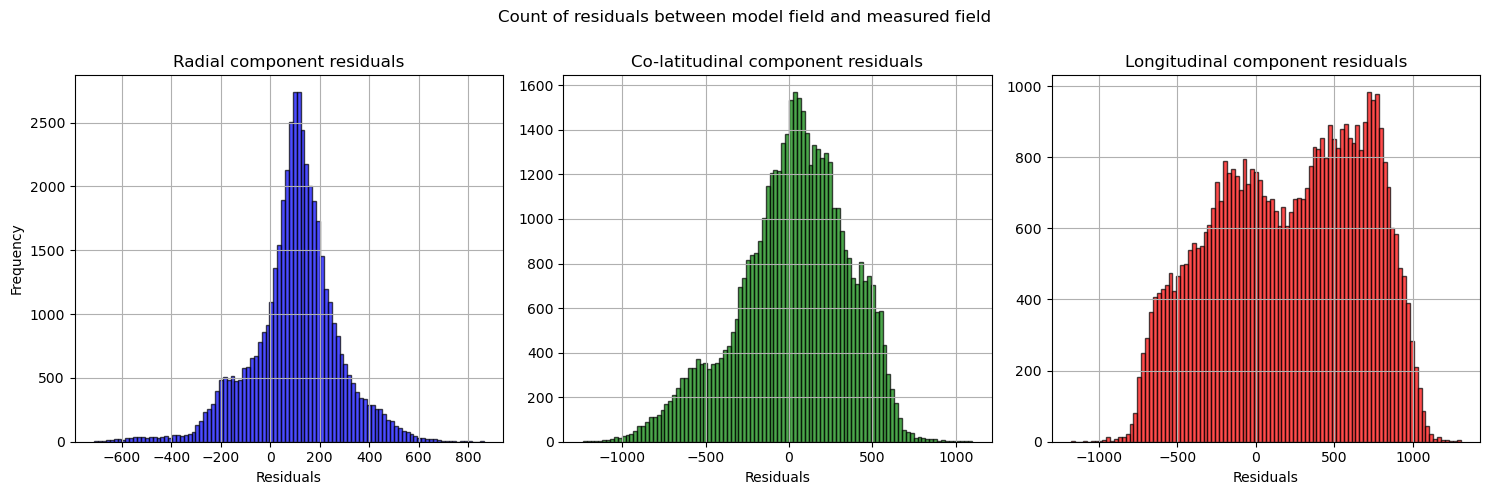

In [11]:
# Residuals
residuals_r_static = data['B_radius'] - b_pred_static_radius
residuals_t_static = data['B_theta'] - b_pred_static_theta
residuals_p_static = data['B_phi'] - b_pred_static_phi


# Plot histogram of residuals
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram of residuals_r
axs[0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Radial component residuals')
axs[0].grid(True)

# Plot histogram of residuals_t
axs[1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Residuals')
# axs[1].set_ylabel('Frequency')
axs[1].set_title('Co-latitudinal component residuals')
axs[1].grid(True)

# Plot histogram of residuals_p
axs[2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[2].set_xlabel('Residuals')
# axs[2].set_ylabel('Frequency')
axs[2].set_title('Longitudinal component residuals')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Count of residuals between model field and measured field')

plt.show()

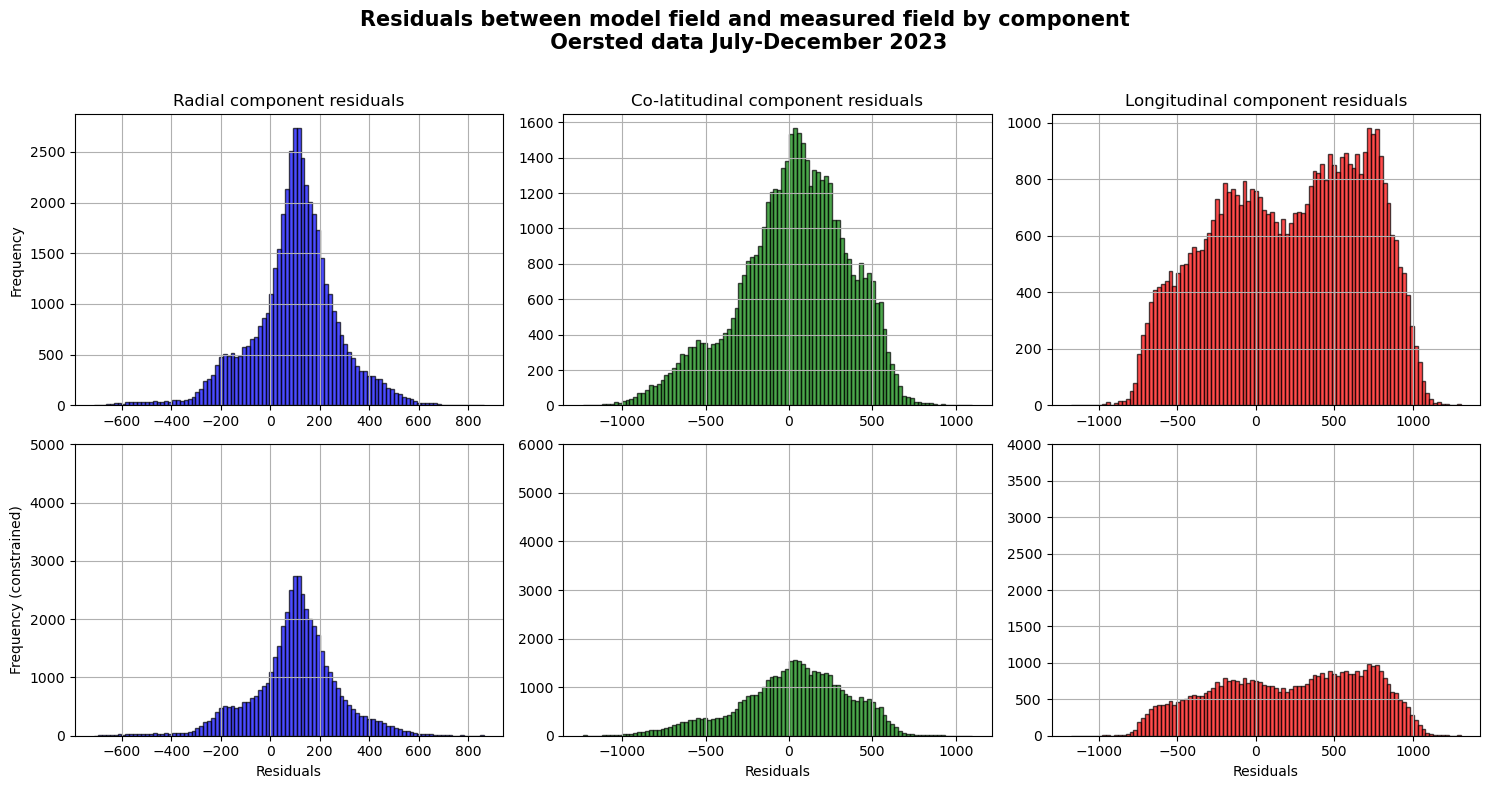

In [12]:
# Plot histogram of residuals
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Plot histogram of residuals_r
axs[0, 0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Radial component residuals')
axs[0, 0].grid(True)

# Plot histogram of residuals_t
axs[0, 1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[0, 1].set_title('Co-latitudinal component residuals')
axs[0, 1].grid(True)

# Plot histogram of residuals_p
axs[0, 2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[0, 2].set_title('Longitudinal component residuals')
axs[0, 2].grid(True)

# Plot histogram of residuals_r (constrained)
axs[1, 0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_ylabel('Frequency (constrained)')
axs[1, 0].set_ylim(0, 5000)
axs[1, 0].grid(True)

# Plot histogram of residuals_t (constrained)
axs[1, 1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1, 1].set_xlabel('Residuals')
axs[1, 1].set_ylim(0, 6000)
axs[1, 1].grid(True)

# Plot histogram of residuals_p (constrained)
axs[1, 2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[1, 2].set_xlabel('Residuals')
axs[1, 2].set_ylim(0, 4000)
axs[1, 2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Residuals between model field and measured field by component\n Oersted data July-December 2023', weight = 'bold', fontsize = 15)

plt.show()

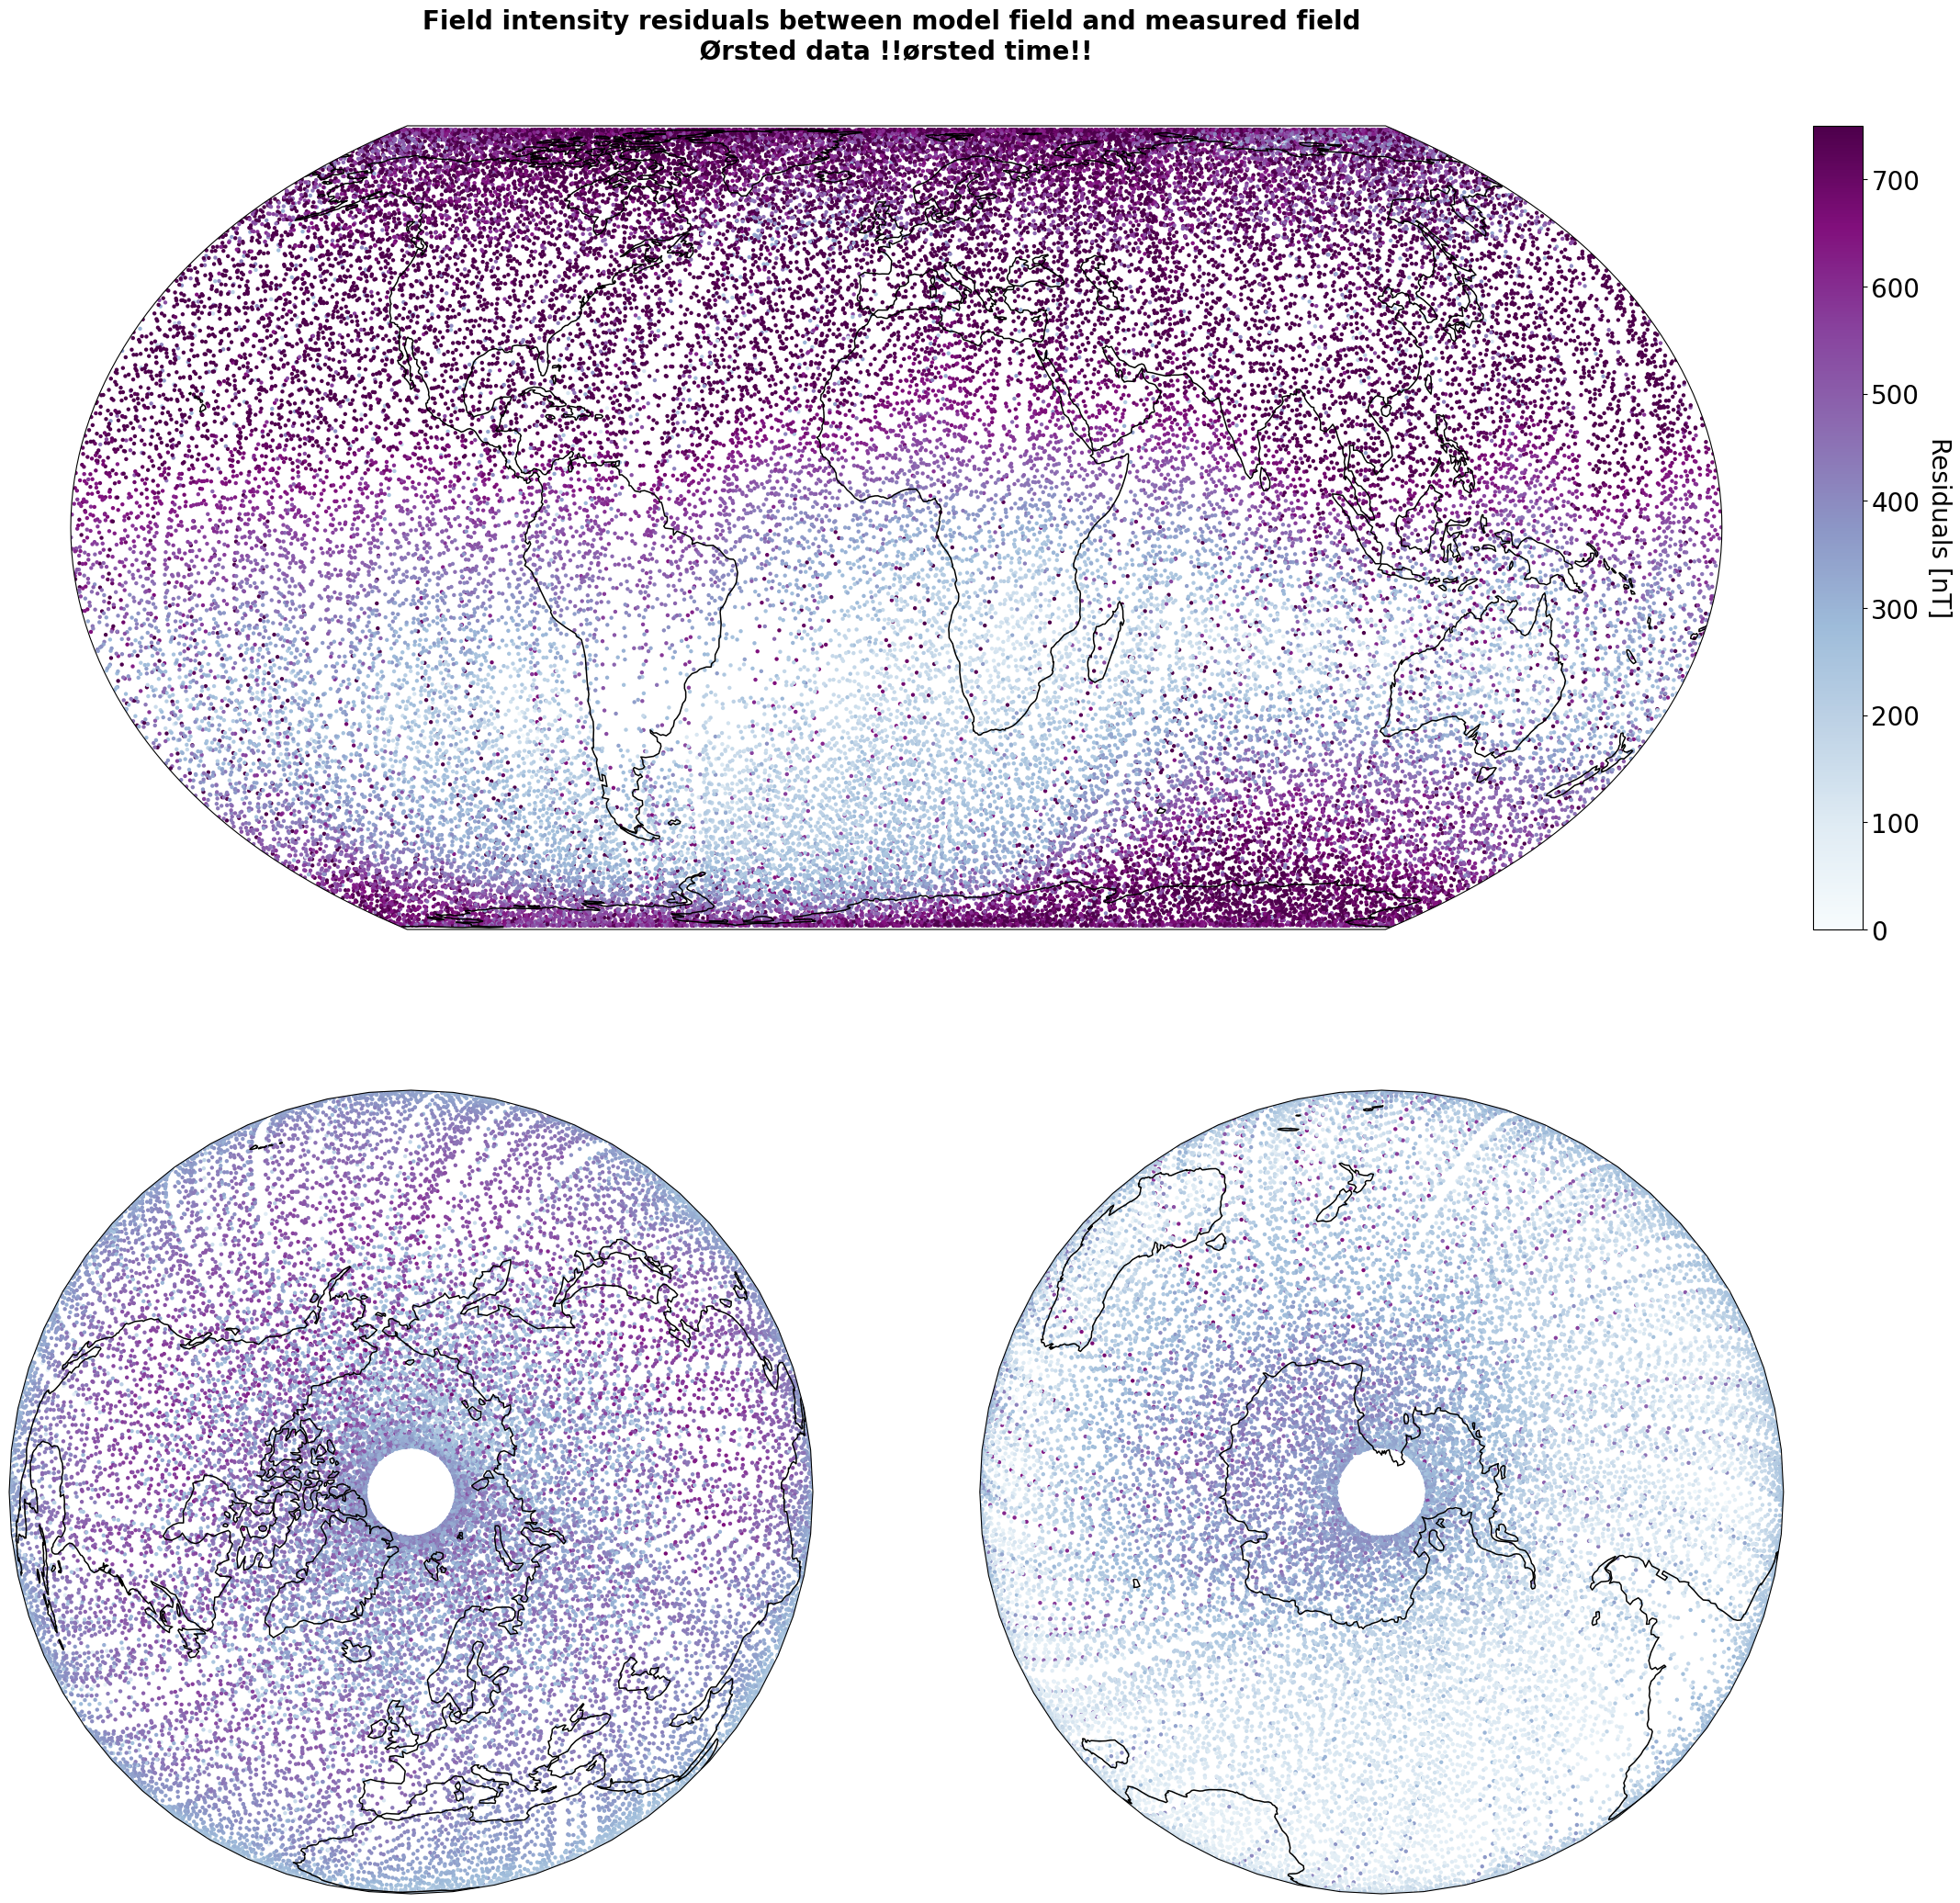

In [14]:
# Intensity of residuals on map
F_residuals = np.sqrt(residuals_r_static**2 + residuals_t_static**2 + residuals_p_static**2)

plot_map_three(F_residuals, data['lon'], data['colat'], 'Oersted', 'Field intensity residuals between model field and measured field', 'Residuals [nT]', scatter_size = 10, clim=[0, 750], colors='BuPu')

# Model with temporal gradient - linear trend of secular variation
